### 2. Multi class classification

#### A. Classification using CNN

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt


# Function to load the data and count digits as labels
def load_mnist_data(dataset_path):
    data = {'train' : [], 'val' : [], 'test' : []}

    for folder_type in os.listdir(dataset_path):
        image_folders = os.path.join(dataset_path, folder_type)
        for label_folders in os.listdir(image_folders):
            label_path = os.path.join(image_folders, label_folders)
            if os.path.isdir(label_path):
                num_digits = len(label_folders)
                label = []
                if num_digits == 1 and label_folders == '0':
                    for i in range(4):
                        label.append(0)
                else:
                    for i in range(4):
                        if i == num_digits:
                            label.append(1)
                        else:
                            label.append(0)

                label = torch.tensor(label)
                for image_file in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_file)
                    data[folder_type].append((image_path, label))

    
    return data


class MultiMNISTDataset():
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


Label: tensor([0, 0, 1, 0])


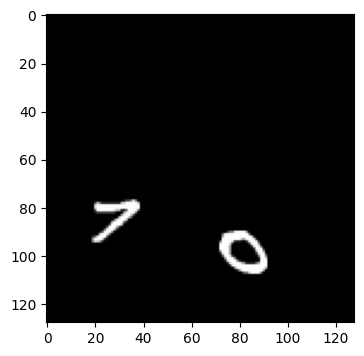

In [2]:
# Try with dataextraction with MultiMNIST dataset

data = load_mnist_data('../../data/external/double_mnist')


transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = MultiMNISTDataset(data['train'], transform=transform)
val_set = MultiMNISTDataset(data['val'], transform=transform)
test_set = MultiMNISTDataset(data['test'], transform=transform)

# Sample image from training set
figure = plt.figure(figsize=(4, 4))
sample_idx = torch.randint(len(train_set), size=(1, )).item()
img, label = train_set[sample_idx]
print(f"Label: {label}")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()


# Make them the training set useful for training efficiently using Dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)


In [3]:
# Training and Evaluating the model

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from models.cnn.cnn import CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, task, loss_function, train_data, val_data):
    model.train()
    trainloss_list = []
    validationloss_list = []

    if model.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate)
    elif model.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=model.learning_rate)
    else:
        raise ValueError('Invalid optimizer')

    for epoch in range(1, model.epochs + 1):
        train_loss = 0
        validation_loss, accuracy = evaluate(model, task, loss_function, val_data)
        for i, (images, labels) in enumerate(train_data):
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            loss = loss_function(output, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_data.dataset)
        trainloss_list.append(avg_train_loss)
        validationloss_list.append(validation_loss)
        print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {validation_loss}, Validation Accuracy: {accuracy}")

    return trainloss_list, validationloss_list


def evaluate(model, task, loss_function, val_data):
    model.eval()
    TP = 0

    with torch.no_grad():
        val_loss = 0
        for i, (images, labels) in enumerate(val_data):
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            loss = loss_function(output, labels)
            val_loss += loss.item()
            if task == 'classification':
                pred = torch.argmax(output, dim=1)
                labels = torch.argmax(labels, dim=1)
            else:
                pred = torch.relu(output)
                pred = torch.round(pred)
                pred = torch.argmax(pred, dim=1)
                labels = torch.argmax(labels, dim=1)

            if task == 'regression':
                TP += torch.sum(pred == labels).item()
            else:
                TP += torch.sum(pred == labels).item()

        avg_loss = val_loss / len(val_data.dataset)

    return avg_loss, TP / len(val_data.dataset)

/home/keshava/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/keshava/Documents/5th sem/SMAI/smai-m24-assignments-Keshavakishorananda/assignments/4/../../models/cnn/cnn.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch: 1, Training Loss: 0.033124492026510695, Validation Loss: 0.0415810542901357, Validation Accuracy: 0.16666666666666666
Epoch: 2, Training Loss: 0.02875622988220245, Validation Loss: 0.028194076915582022, Validation Accuracy: 0.7883333333333333
Epoch: 3, Training Loss: 0.025184349606907557, Validation Loss: 0.027739036699136098, Validation Accuracy: 0.8036666666666666
Epoch: 4, Training Loss: 0.0232919414648934, Validation Loss: 0.02362157040834427, Validation Accuracy: 0.9343333333333333
Epoch: 5, Training Loss: 0.023048675003505888, Validation Loss: 0.022839763383070626, Validation Accuracy: 0.9573333333333334
Epoch: 6, Training Loss: 0.022921875573339915, Validation Loss: 0.022815388202667236, Validation Accuracy: 0.959
Epoch: 7, Training Loss: 0.02280018631428007, Validation Loss: 0.022970785081386565, Validation Accuracy: 0.9516666666666667
Epoch: 8, Training Loss: 0.02277983404341198, Validation Loss: 0.022661559343338012, Validation Accuracy: 0.9626666666666667
Epoch: 9, Tr

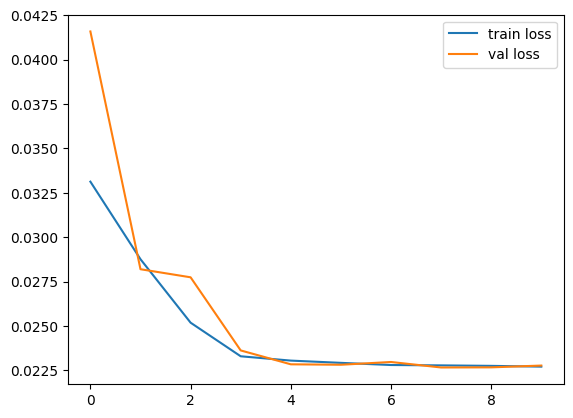

Test loss: 0.023191949245722397, Test accuracy: 0.965
Validation loss: 0.022681685447692872, Validation accuracy: 0.9616666666666667


In [4]:
# Sample model for classification

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2

classification_model = CNN('classification', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
classification_model.to(device)

loss_function = nn.CrossEntropyLoss()
loss_train, loss_val = train(classification_model, 'classification', loss_function, train_loader, val_loader)


print("Training completed")
plt.plot(loss_train, label='train loss')
plt.plot(loss_val, label='val loss')
plt.legend()
plt.show()
plt.close()

# Testing the sample model
test_loss, test_accuracy = evaluate(classification_model, 'classification', loss_function, test_loader)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

val_loss, val_accuracy = evaluate(classification_model, 'classification', loss_function, val_loader)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

Epoch: 1, Training Loss: 0.03401401394416415, Validation Loss: 0.04211341389020284, Validation Accuracy: 0.224
Epoch: 2, Training Loss: 0.028794547660010203, Validation Loss: 0.02810017470518748, Validation Accuracy: 0.792
Epoch: 3, Training Loss: 0.028042700427865226, Validation Loss: 0.02796350304285685, Validation Accuracy: 0.7936666666666666
Epoch: 4, Training Loss: 0.023818353248967066, Validation Loss: 0.02510006974140803, Validation Accuracy: 0.8776666666666667
Epoch: 5, Training Loss: 0.02305290015443923, Validation Loss: 0.02282213185230891, Validation Accuracy: 0.9586666666666667
Epoch: 6, Training Loss: 0.022738130721780988, Validation Loss: 0.022859714488188427, Validation Accuracy: 0.9566666666666667
Epoch: 7, Training Loss: 0.02258159644546963, Validation Loss: 0.022879900634288786, Validation Accuracy: 0.956
Epoch: 8, Training Loss: 0.02245570403715921, Validation Loss: 0.02263878458738327, Validation Accuracy: 0.964
Epoch: 9, Training Loss: 0.02240505597421101, Validati

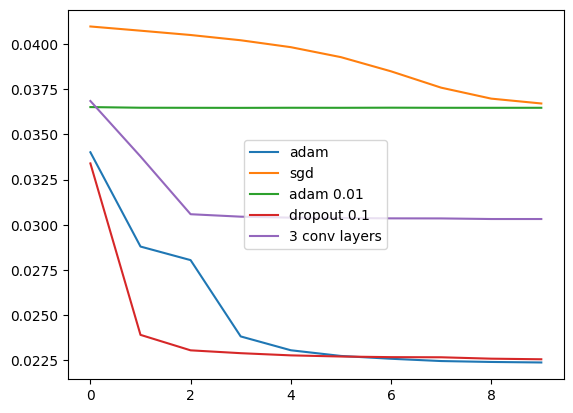

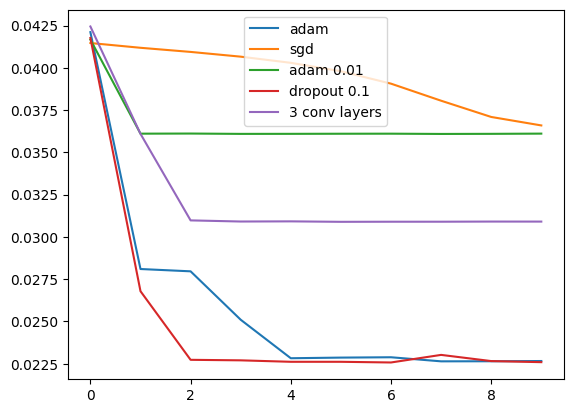

Test loss: 0.022817514279614325, Test accuracy: 0.9771739130434782
Validation loss: 0.02261605817079544, Validation accuracy: 0.9643333333333334


In [5]:
# Hyperparameter tuning

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2

classification_model1 = CNN('classification', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
classification_model1.to(device)
loss_function = nn.CrossEntropyLoss()
loss_train1, loss_val1 = train(classification_model1, 'classification', loss_function, train_loader, val_loader)

classification_model2 = CNN('classification', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'sgd', 10, 0.001)
classification_model2.to(device)
loss_function = nn.CrossEntropyLoss()
loss_train2, loss_val2 = train(classification_model2, 'classification', loss_function, train_loader, val_loader)

classification_model3 = CNN('classification', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.01)
classification_model3.to(device)
loss_function = nn.CrossEntropyLoss()
loss_train3, loss_val3 = train(classification_model3, 'classification', loss_function, train_loader, val_loader)

dropout = 0.1
classification_model4 = CNN('classification', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
classification_model4.to(device)
loss_function = nn.CrossEntropyLoss()
loss_train4, loss_val4 = train(classification_model4, 'classification', loss_function, train_loader, val_loader)

conv_layers = [4, 16, 32]
filters = [[(2, 2), 2], [(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu, F.relu]
dropout = 0.2
classification_model5 = CNN('classification', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
classification_model5.to(device)
loss_function = nn.CrossEntropyLoss()
loss_train5, loss_val5 = train(classification_model5, 'classification', loss_function, train_loader, val_loader)

# plot the results for both validation and training loss
plt.plot(loss_train1, label='adam')
plt.plot(loss_train2, label='sgd')
plt.plot(loss_train3, label='adam 0.01')
plt.plot(loss_train4, label='dropout 0.1')
plt.plot(loss_train5, label='3 conv layers')
plt.legend()
plt.show()
plt.close()

plt.plot(loss_val1, label='adam')
plt.plot(loss_val2, label='sgd')
plt.plot(loss_val3, label='adam 0.01')
plt.plot(loss_val4, label='dropout 0.1')
plt.plot(loss_val5, label='3 conv layers')
plt.legend()
plt.show()
plt.close()

# Testing the best model
test_loss, test_accuracy = evaluate(classification_model1, 'classification', loss_function, test_loader)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

val_loss, val_accuracy = evaluate(classification_model1, 'classification', loss_function, val_loader)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

In [5]:
# Feature map visualization for three images from the test set of the best model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from models.cnn.cnn import CNN

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2
featuremap_model = CNN('classification', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
featuremap_model.to(device)
loss_function = nn.CrossEntropyLoss()
loss_train, loss_val = train(featuremap_model, 'classification', loss_function, train_loader, val_loader)

/home/keshava/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
/home/keshava/Documents/5th sem/SMAI/smai-m24-assignments-Keshavakishorananda/assignments/4/../../models/cnn/cnn.py:77: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch: 1, Training Loss: 0.03151150963136128, Validation Loss: 0.04144284602006276, Validation Accuracy: 0.5333333333333333
Epoch: 2, Training Loss: 0.024605303425637503, Validation Loss: 0.02467143734296163, Validation Accuracy: 0.9203333333333333
Epoch: 3, Training Loss: 0.023955353460614642, Validation Loss: 0.023218940893809, Validation Accuracy: 0.9463333333333334
Epoch: 4, Training Loss: 0.02355179347216137, Validation Loss: 0.022992147982120514, Validation Accuracy: 0.955
Epoch: 5, Training Loss: 0.023269671911285036, Validation Loss: 0.02278433346748352, Validation Accuracy: 0.96
Epoch: 6, Training Loss: 0.0229027554108983, Validation Loss: 0.02308905412753423, Validation Accuracy: 0.9486666666666667
Epoch: 7, Training Loss: 0.022586931051715973, Validation Loss: 0.022726273397604625, Validation Accuracy: 0.9603333333333334
Epoch: 8, Training Loss: 0.022447702127789695, Validation Loss: 0.02261427785952886, Validation Accuracy: 0.965
Epoch: 9, Training Loss: 0.02239481995030055

Label: tensor([0, 0, 1, 0])
Image number: 1


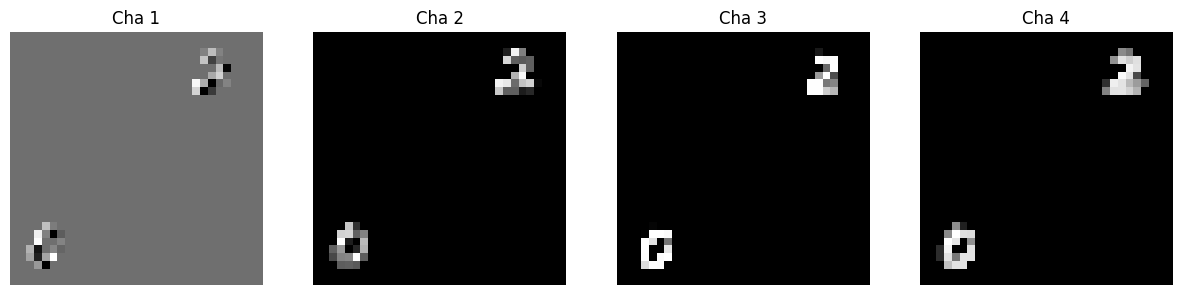

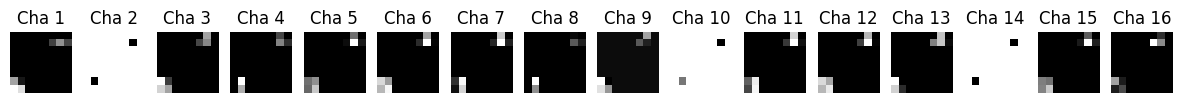

Label: tensor([0, 1, 0, 0])
Image number: 2


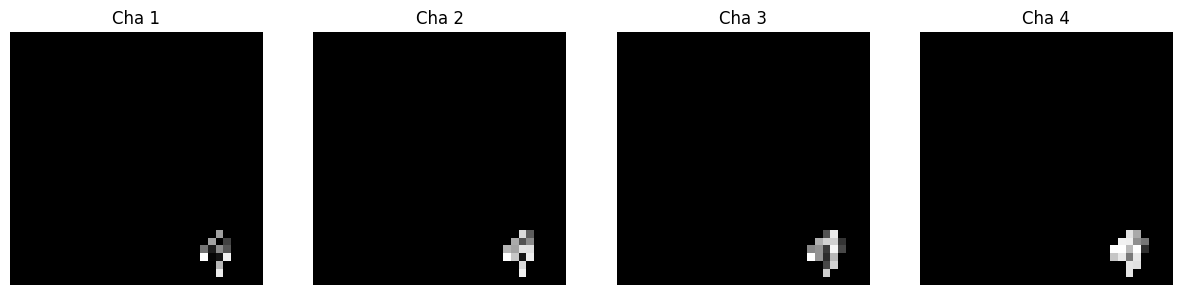

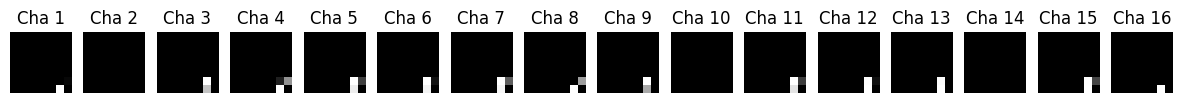

Label: tensor([0, 1, 0, 0])
Image number: 3


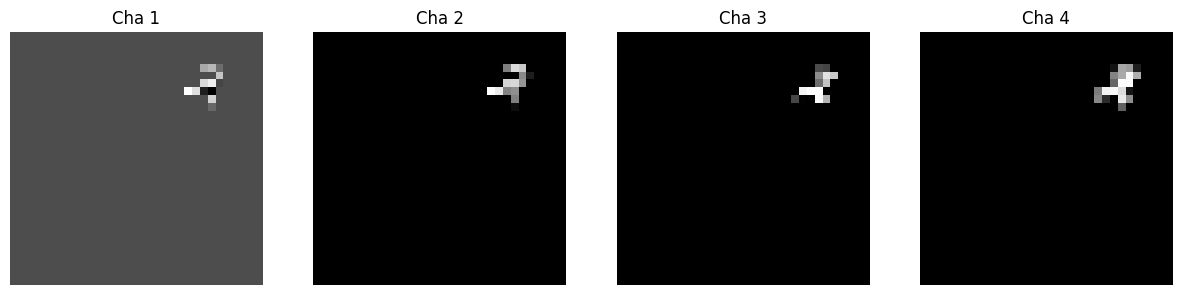

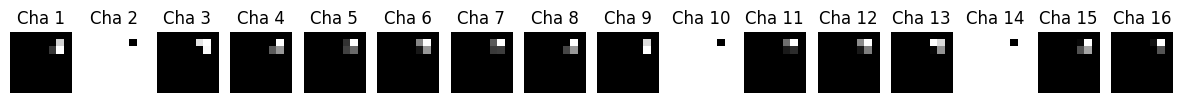

In [16]:
import torch
import matplotlib.pyplot as plt

def plot_feature_maps(model, image, device='cuda'):
    model.to(device)
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        _ = model(image)
        feature_maps = model.get_feature_maps()  
        
        # Plot each feature map
        for i, feature_map in enumerate(feature_maps):
            num_channels = feature_map.shape[1]
            fig, axes = plt.subplots(1, num_channels, figsize=(15, 15))
            for j in range(num_channels):
                axes[j].imshow(feature_map[0, j].cpu().numpy(), cmap='gray')
                axes[j].set_title(f'Cha {j + 1}')
                axes[j].axis('off')
            plt.show()

# Visualize feature maps for the first three images in the test set
for i in range(3):
    idx = torch.randint(len(test_set), size=(1, )).item()
    image, label = test_set[idx]
    print(f"Label: {label}")
    print(f"Image number: {i + 1}")
    plot_feature_maps(featuremap_model, image)


#### Observations about Feature Maps:
- Unable to say accuarately which feature map is representing which feature.
- But we can say that feature maps after two layers are representing how many pixels the number id occupying in the image and also position of it the image.
- feature map after one layer is trying to represent the edges of the number in the image.

#### B. Regression using CNN

Epoch: 1, Training Loss: 0.002200930771521396, Validation Loss: 0.012741176625092825, Validation Accuracy: 0.03333333333333333
Epoch: 2, Training Loss: 0.0004094798174420638, Validation Loss: 0.0006171327860405048, Validation Accuracy: 0.956
Epoch: 3, Training Loss: 0.00011844088045311056, Validation Loss: 0.00018793810384037593, Validation Accuracy: 0.9983333333333333
Epoch: 4, Training Loss: 6.0959075635764745e-05, Validation Loss: 9.365752836068471e-05, Validation Accuracy: 0.9993333333333333
Epoch: 5, Training Loss: 4.018341517260682e-05, Validation Loss: 9.510031559815009e-05, Validation Accuracy: 0.9976666666666667
Epoch: 6, Training Loss: 3.0216343891677552e-05, Validation Loss: 7.17584506298105e-05, Validation Accuracy: 0.997
Epoch: 7, Training Loss: 2.2721163087038487e-05, Validation Loss: 4.584867441250632e-05, Validation Accuracy: 0.9983333333333333
Epoch: 8, Training Loss: 2.3421591947211824e-05, Validation Loss: 4.811930546808678e-05, Validation Accuracy: 0.998666666666666

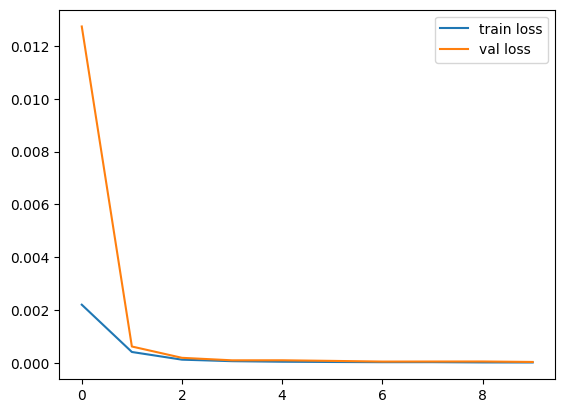

Test loss: 3.693790340469644e-05, Test accuracy: 0.9986956521739131
Validation loss: 3.3599698222436325e-05, Validation accuracy: 0.999


In [6]:
# Sample model for regression

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2

regression_model = CNN('regression', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
regression_model.to(device)
loss_function = nn.MSELoss()
loss_train, loss_val = train(regression_model, 'regression', loss_function, train_loader, val_loader)

print("Training completed")
plt.plot(loss_train, label='train loss')
plt.plot(loss_val, label='val loss')
plt.legend()
plt.show()
plt.close()

# Testing the sample model
test_loss, test_accuracy = evaluate(regression_model, 'regression', loss_function, test_loader)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

val_loss, val_accuracy = evaluate(regression_model, 'regression', loss_function, val_loader)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

Epoch: 1, Training Loss: 0.003574453733329262, Validation Loss: 0.006413714423775673, Validation Accuracy: 0.03333333333333333
Epoch: 2, Training Loss: 0.0011266788189846371, Validation Loss: 0.0015450723096728325, Validation Accuracy: 0.7733333333333333
Epoch: 3, Training Loss: 0.000628036254063426, Validation Loss: 0.0004490932848614951, Validation Accuracy: 0.9476666666666667
Epoch: 4, Training Loss: 0.00025732732945702054, Validation Loss: 0.00046822789357975125, Validation Accuracy: 0.973
Epoch: 5, Training Loss: 6.744554314608982e-05, Validation Loss: 0.00013449603078576425, Validation Accuracy: 0.994
Epoch: 6, Training Loss: 3.2713753446134635e-05, Validation Loss: 8.052879694635824e-05, Validation Accuracy: 0.9966666666666667
Epoch: 7, Training Loss: 2.4044494270966094e-05, Validation Loss: 6.303465282932545e-05, Validation Accuracy: 0.9963333333333333
Epoch: 8, Training Loss: 1.6676928618893265e-05, Validation Loss: 5.391217124027511e-05, Validation Accuracy: 0.996666666666666

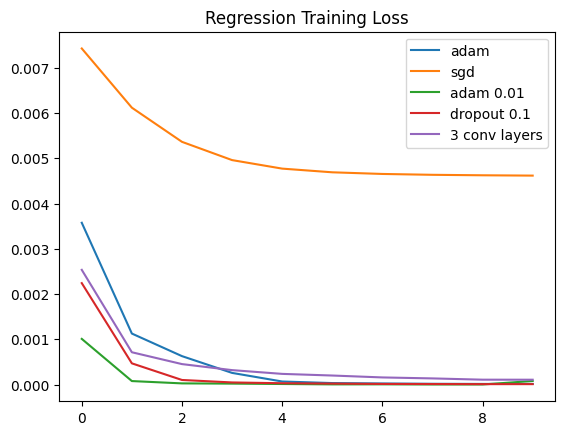

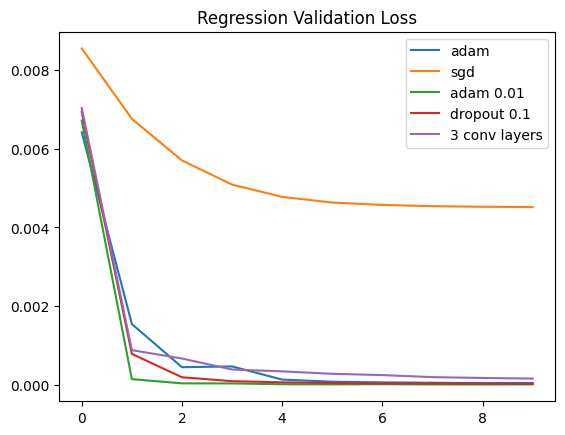

Test loss: 3.2504711691770985e-05, Test accuracy: 0.9984782608695653
Validation loss: 4.3242662456274654e-05, Validation accuracy: 0.9973333333333333


In [8]:
# Hyper parameter tuning

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2

regression_model1 = CNN('regression', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
regression_model1.to(device)
loss_function = nn.MSELoss()
loss_train1, loss_val1 = train(regression_model1, 'regression', loss_function, train_loader, val_loader)

regression_model2 = CNN('regression', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'sgd', 10, 0.001)
regression_model2.to(device)
loss_function = nn.MSELoss()
loss_train2, loss_val2 = train(regression_model2, 'regression', loss_function, train_loader, val_loader)

regression_model3 = CNN('regression', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.01)
regression_model3.to(device)
loss_function = nn.MSELoss()
loss_train3, loss_val3 = train(regression_model3, 'regression', loss_function, train_loader, val_loader)

dropout = 0.1
regression_model4 = CNN('regression', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
regression_model4.to(device)
loss_function = nn.MSELoss()
loss_train4, loss_val4 = train(regression_model4, 'regression', loss_function, train_loader, val_loader)

conv_layers = [4, 16, 32]
filters = [[(2, 2), 2], [(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu, F.relu]
dropout = 0.2
regression_model5 = CNN('regression', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
regression_model5.to(device)
loss_function = nn.MSELoss()
loss_train5, loss_val5 = train(regression_model5, 'regression', loss_function, train_loader, val_loader)

# plot the results for both validation and training loss
plt.plot(loss_train1, label='adam')
plt.plot(loss_train2, label='sgd')
plt.plot(loss_train3, label='adam 0.01')
plt.plot(loss_train4, label='dropout 0.1')
plt.plot(loss_train5, label='3 conv layers')
plt.legend()
plt.title('Regression Training Loss')
plt.show()
plt.close()

plt.plot(loss_val1, label='adam')
plt.plot(loss_val2, label='sgd')
plt.plot(loss_val3, label='adam 0.01')
plt.plot(loss_val4, label='dropout 0.1')
plt.plot(loss_val5, label='3 conv layers')
plt.legend()
plt.title('Regression Validation Loss')
plt.show()
plt.close()


# Testing the best model
test_loss, test_accuracy = evaluate(regression_model1, 'regression', loss_function, test_loader)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

val_loss, val_accuracy = evaluate(regression_model1, 'regression', loss_function, val_loader)
print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")


In [17]:
# Feature map visualization for three images from the test set of the best model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from models.cnn.cnn import CNN

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [64, 16, 4]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2
featuremap_model = CNN('regression', 128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
featuremap_model.to(device)
loss_function = nn.MSELoss()
loss_train, loss_val = train(featuremap_model, 'regression', loss_function, train_loader, val_loader)

Epoch: 1, Training Loss: 0.0022643456481663245, Validation Loss: 0.009801932841539383, Validation Accuracy: 0.03333333333333333
Epoch: 2, Training Loss: 0.0006827987768199472, Validation Loss: 0.0008010308298592766, Validation Accuracy: 0.942
Epoch: 3, Training Loss: 0.00035043112286883924, Validation Loss: 0.00037820791577299436, Validation Accuracy: 0.965
Epoch: 4, Training Loss: 0.00017729452477180442, Validation Loss: 0.0001789168460139384, Validation Accuracy: 0.997
Epoch: 5, Training Loss: 0.0001172201993962055, Validation Loss: 0.00010269185594127823, Validation Accuracy: 0.998
Epoch: 6, Training Loss: 9.218412037986878e-05, Validation Loss: 7.681128421487907e-05, Validation Accuracy: 0.9976666666666667
Epoch: 7, Training Loss: 8.441396669710115e-05, Validation Loss: 8.282931283853638e-05, Validation Accuracy: 0.998
Epoch: 8, Training Loss: 7.384265318655202e-05, Validation Loss: 7.568242235962923e-05, Validation Accuracy: 0.9986666666666667
Epoch: 9, Training Loss: 5.7372687953

Label: tensor([0, 1, 0, 0])
Image number: 1


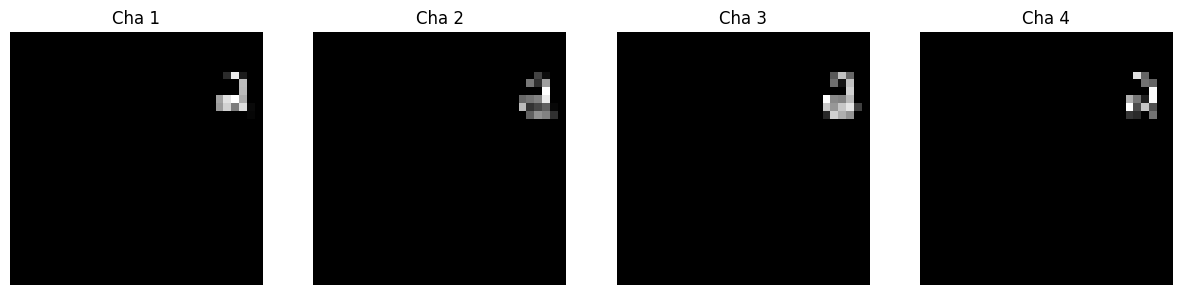

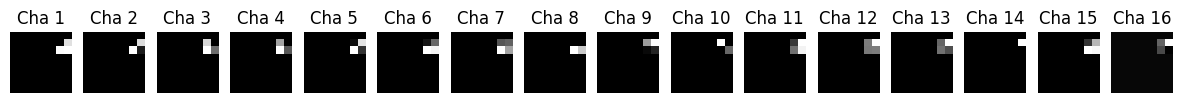

Label: tensor([0, 0, 0, 1])
Image number: 2


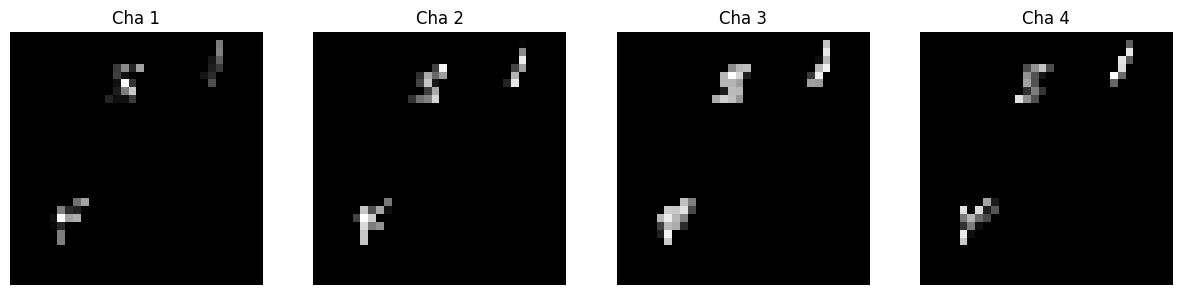

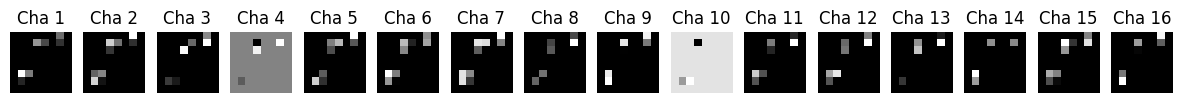

Label: tensor([0, 0, 1, 0])
Image number: 3


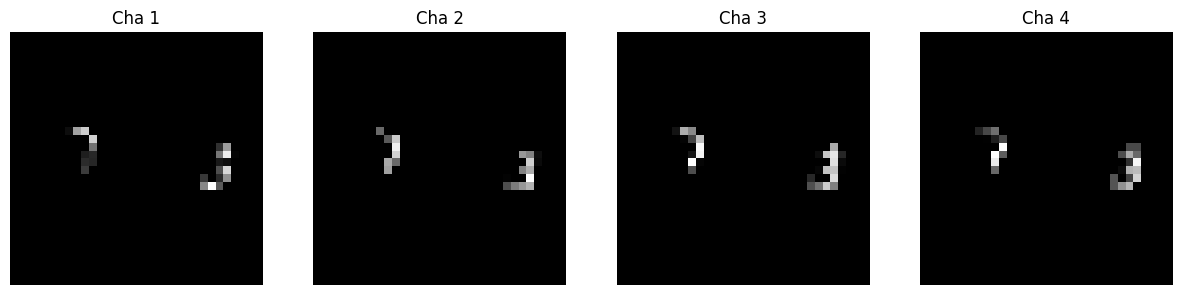

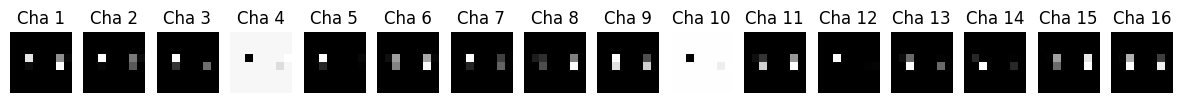

In [18]:
# Visualize feature maps for the first three images in the test set

def plot_feature_maps(model, image, device='cuda'):
    model.to(device)
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        _ = model(image)
        feature_maps = model.get_feature_maps()  
        
        # Plot each feature map
        for i, feature_map in enumerate(feature_maps):
            num_channels = feature_map.shape[1]
            fig, axes = plt.subplots(1, num_channels, figsize=(15, 15))
            for j in range(num_channels):
                axes[j].imshow(feature_map[0, j].cpu().numpy(), cmap='gray')
                axes[j].set_title(f'Cha {j + 1}')
                axes[j].axis('off')
            plt.show()

for i in range(3):
    idx = torch.randint(len(test_set), size=(1, )).item()
    image, label = test_set[idx]
    print(f"Label: {label}")
    print(f"Image number: {i + 1}")
    plot_feature_maps(featuremap_model, image)


#### Observations about Feature Maps:
- Unable to say accuarately which feature map is representing which feature.
- But we can say that feature maps after two layers are representing how many pixels the number id occupying in the image and also position of it the image.
- feature map after one layer is trying to represent the edges of the number in the image.

### 3. Multi-label Classification

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


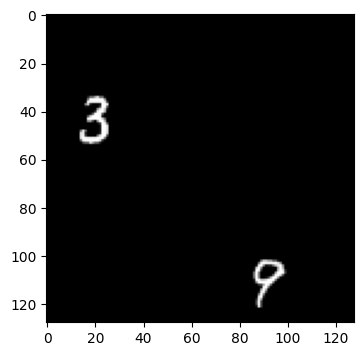

In [23]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt

# Load the Multi-label dataset

def load_mnist_data(dataset_path):
    data = {'train' : [], 'val' : [], 'test' : []}

    for folder_type in os.listdir(dataset_path):
        image_folders = os.path.join(dataset_path, folder_type)
        for label_folders in os.listdir(image_folders):
            label_path = os.path.join(image_folders, label_folders)
            if os.path.isdir(label_path):
                if label_folders == '0':
                    label = [0 for _ in range(30)]
                else:
                    if len(label_folders) == 1:
                        label = [1 if i == int(label_folders) else 0 for i in range(10)]
                        label += [0 for _ in range(20)]

                    elif len(label_folders) == 2:
                        label = [1 if i == int(label_folders[0]) else 0 for i in range(10)]
                        label += [1 if i == int(label_folders[1]) else 0 for i in range(10)]
                        label += [0 for _ in range(10)]

                    elif len(label_folders) == 3:
                        label = [1 if i == int(label_folders[0]) else 0 for i in range(10)]
                        label += [1 if i == int(label_folders[1]) else 0 for i in range(10)]
                        label += [1 if i == int(label_folders[2]) else 0 for i in range(10)]


                for image_file in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_file)
                    data[folder_type].append((image_path, label))



    return data

class MultiMNISTDataset():
    def __init__(self, data, transform = None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float).view(3, 10)
        return image, label


mutli_data = load_mnist_data('../../data/external/double_mnist')

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = MultiMNISTDataset(mutli_data['train'], transform=transform)
val_set = MultiMNISTDataset(mutli_data['val'], transform=transform)
test_set = MultiMNISTDataset(mutli_data['test'], transform=transform)

# Sample image from training set
figure = plt.figure(figsize=(4, 4))
sample_idx = torch.randint(len(val_set), size=(1, )).item()
img, label = val_set[sample_idx]
print(label)
plt.imshow(img.squeeze(), cmap="gray")
plt.show()


# Make them the training set useful for training efficiently using Dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [24]:
# Training and Evaluating the model

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from models.cnn.multilabel_cnn import Multilabel_CNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, loss_function, train_loader, validation_loader):
    model.train()
    trainloss_list = []
    validationloss_list = []

    if model.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=model.learning_rate)
    elif model.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=model.learning_rate)
    

    for epoch in range(1, model.epochs+1):
        train_loss = 0
        validation_loss, Hammin_acc, exact_acc = evaluate(model, loss_function, validation_loader)
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            output = output.view(-1, 3, 10)
            loss = loss_function(output, labels)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader.dataset)
        trainloss_list.append(avg_loss)
        validationloss_list.append(validation_loss)
        
        print(f"Epoch {epoch}, train loss: {avg_loss}, val loss: {validation_loss}")

    return trainloss_list, validationloss_list


def evaluate(model, loss_function, val_data):
    model.eval()
    exact_match = 0
    total_samples = 0
    hamming_matches = 0
    total_predictions = 0

    with torch.no_grad():
        val_loss = 0
        for i,(images, labels) in enumerate(val_data):
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            output = output.view(-1, 3, 10)
            loss = loss_function(output, labels)
            val_loss += loss.item()

            # Calculate Hamming accuracy and Exact match accuracy
            pred = torch.round(output)
            hamming_matches += torch.sum(pred == labels).item()
            total_predictions += pred.numel()

            exact_match += torch.sum(torch.all(pred == labels, dim=(1, 2))).item()
            total_samples += pred.size(0)

        avg_loss = val_loss / len(val_data.dataset)
        Hamming_accuracy = hamming_matches / total_predictions
        Exact_accuracy = exact_match / total_samples

    return avg_loss, Hamming_accuracy, Exact_accuracy



In [25]:
# Training the model for Multilabel-classification

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [128, 64, 30]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2

Multilabel_classification_model = Multilabel_CNN(128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
Multilabel_classification_model.to(device)
training_loss, validation_loss = train(Multilabel_classification_model, nn.BCELoss(), train_loader, val_loader)

Epoch 1, train loss: 0.008271765206083064, val loss: 0.021736557364463806
Epoch 2, train loss: 0.007520946338551031, val loss: 0.00777964006861051
Epoch 3, train loss: 0.0074361339586210395, val loss: 0.007666760971148809
Epoch 4, train loss: 0.007284708340792725, val loss: 0.007574228962262472
Epoch 5, train loss: 0.007242439917384809, val loss: 0.007562897751728694
Epoch 6, train loss: 0.007139678133673788, val loss: 0.007565845216313998
Epoch 7, train loss: 0.007005998184867499, val loss: 0.0074256188993652664
Epoch 8, train loss: 0.006976004444387934, val loss: 0.007216632166256507
Epoch 9, train loss: 0.006893951633708581, val loss: 0.0072986403132478395
Epoch 10, train loss: 0.006863624510865304, val loss: 0.007209155932068825


In [26]:
# Testing the model
test_loss, hamming_accuracy, exact_accuracy = evaluate(Multilabel_classification_model, nn.BCEWithLogitsLoss(), test_loader)
print(f"Test loss: {test_loss}, Hamming accuracy: {hamming_accuracy}, Exact accuracy: {exact_accuracy}")

Test loss: 0.022725655242152837, Hamming accuracy: 0.9384057971014492, Exact accuracy: 0.021739130434782608


Epoch 1, train loss: 0.008353530999406108, val loss: 0.02189091380437215
Epoch 2, train loss: 0.007451771545105628, val loss: 0.007733012020587921
Epoch 3, train loss: 0.0073157369962612556, val loss: 0.007597417091329893
Epoch 4, train loss: 0.00717057772269029, val loss: 0.0074198754454652465
Epoch 5, train loss: 0.007059357497427199, val loss: 0.007292837680627902
Epoch 6, train loss: 0.006983724156291121, val loss: 0.00723718449473381
Epoch 7, train loss: 0.006922431227359329, val loss: 0.0073634690220157305
Epoch 8, train loss: 0.00685317039223654, val loss: 0.007141386575375994
Epoch 9, train loss: 0.006888918750605265, val loss: 0.007115766989688079
Epoch 10, train loss: 0.006822027993824569, val loss: 0.007196267756943902
Epoch 1, train loss: 0.02143081215638963, val loss: 0.02160867206255595
Epoch 2, train loss: 0.021232674093473524, val loss: 0.02138335245847702
Epoch 3, train loss: 0.021050634161820486, val loss: 0.021202885230382284
Epoch 4, train loss: 0.02085396715572902,

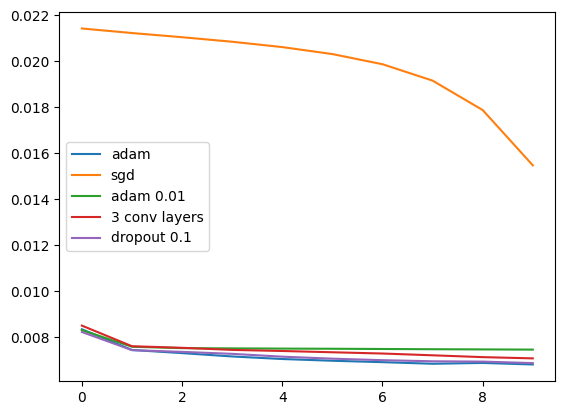

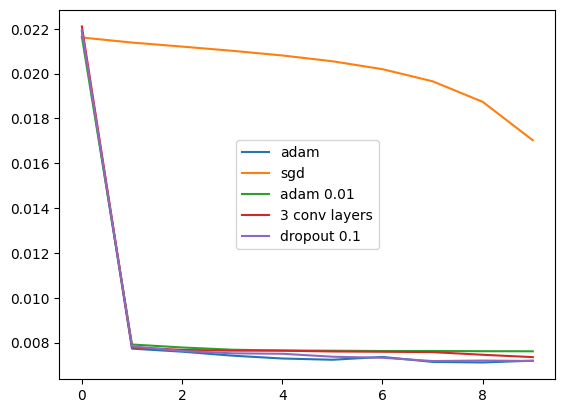

In [30]:
# Hyper parameter tuning

# write different hyperparameters to try
import sys
sys.path.append('../../')
from models.cnn.multilabel_cnn import Multilabel_CNN

loss_list = []

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [128, 64, 30]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2
model1 = Multilabel_CNN(128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
model1.to(device)
loss_function = nn.BCELoss()
loss_train1, loss_val1 = train(model1, loss_function, train_loader, val_loader)


conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [128, 64, 30]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2
model2 = Multilabel_CNN(128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'sgd', 10, 0.001)
model2.to(device)
loss_function = nn.BCELoss()
loss_train2, loss_val2 = train(model2, loss_function, train_loader, val_loader)

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [128, 64, 30]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2
model3 = Multilabel_CNN(128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.01)
model3.to(device)
loss_function = nn.BCELoss()
loss_train3, loss_val3 = train(model3, loss_function, train_loader, val_loader)

conv_layers = [4, 16, 32]
filters = [[(2, 2), 2], [(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2], [(2, 2), 2]]
full_layers = [128, 64, 30]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2
model4 = Multilabel_CNN(128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
model4.to(device)
loss_function = nn.BCELoss()
loss_train4, loss_val4 = train(model4, loss_function, train_loader, val_loader)

conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [128, 64, 30]
activations = [F.relu, F.relu, F.relu]
dropout = 0.1
model5 = Multilabel_CNN(128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
model5.to(device)
loss_function = nn.BCELoss()
loss_train5, loss_val5 = train(model5, loss_function, train_loader, val_loader)

# plot the results for both validation and training loss
plt.plot(loss_train1, label='adam')
plt.plot(loss_train2, label='sgd')
plt.plot(loss_train3, label='adam 0.01')
plt.plot(loss_train4, label='3 conv layers')
plt.plot(loss_train5, label='dropout 0.1')
plt.legend()
plt.show()
plt.close()

plt.plot(loss_val1, label='adam')
plt.plot(loss_val2, label='sgd')
plt.plot(loss_val3, label='adam 0.01')
plt.plot(loss_val4, label='3 conv layers')
plt.plot(loss_val5, label='dropout 0.1')
plt.legend()
plt.show()
plt.close()



In [31]:
# Best model
conv_layers = [4, 16]
filters = [[(2, 2), 2], [(2, 2), 2]]
pool_layers = [[(2, 2), 2], [(2, 2), 2]]
full_layers = [128, 64, 30]
activations = [F.relu, F.relu, F.relu]
dropout = 0.2
best_model = Multilabel_CNN(128, 128, conv_layers, filters, pool_layers, full_layers, activations, dropout, 'adam', 10, 0.001)
best_model.to(device)


# Training the best model
training_loss, validation_loss = train(best_model, nn.BCELoss(), train_loader, val_loader)
print("Training completed")


test_loss, hamming_accuracy, exact_accuracy = evaluate(best_model, nn.BCEWithLogitsLoss(), test_loader)
print(f"Test loss: {test_loss}, Hamming accuracy: {hamming_accuracy}, Exact accuracy: {exact_accuracy}")

val_loss, val_hamming_accuracy, val_exact_accuracy = evaluate(best_model, nn.BCEWithLogitsLoss(), val_loader)
print(f"Validation loss: {val_loss}, Validation Hamming accuracy: {val_hamming_accuracy}, Validation Exact accuracy: {val_exact_accuracy}")

train_loss, train_hamming_accuracy, train_exact_accuracy = evaluate(best_model, nn.BCEWithLogitsLoss(), train_loader)
print(f"Train loss: {train_loss}, Train Hamming accuracy: {train_hamming_accuracy}, Train Exact accuracy: {train_exact_accuracy}")

Epoch 1, train loss: 0.008092588922082786, val loss: 0.021298765957355498
Epoch 2, train loss: 0.007465165018562286, val loss: 0.007837021028002104
Epoch 3, train loss: 0.0073834540326488275, val loss: 0.007656577964623769
Epoch 4, train loss: 0.007206636202588145, val loss: 0.007580428863565127
Epoch 5, train loss: 0.0070896098702879886, val loss: 0.007500425639251868
Epoch 6, train loss: 0.007055374790603916, val loss: 0.007468383118510246
Epoch 7, train loss: 0.006993881768199601, val loss: 0.007313798053810994
Epoch 8, train loss: 0.006940765991171319, val loss: 0.007258164624373118
Epoch 9, train loss: 0.006906616554248132, val loss: 0.007151219638685385
Epoch 10, train loss: 0.006854334553566924, val loss: 0.00713000748368601
Training completed
Test loss: 0.022654929588670315, Hamming accuracy: 0.9384057971014492, Exact accuracy: 0.021739130434782608
Validation loss: 0.022634544710318248, Validation Hamming accuracy: 0.9322222222222222, Validation Exact accuracy: 0.03333333333333